In [843]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp
import pylab
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import NoiseModel

In [844]:
labels = ["II", "IZ", "ZI", "ZZ", "XX"]
coeffs = [-1.052, 0.398, -0.398, -0.011, 0.181]
sp = SparsePauliOp(labels, coeffs)
hamiltonian = PauliSumOp(sp)

print(hamiltonian)

-1.052 * II
+ 0.398 * IZ
- 0.398 * ZI
- 0.011 * ZZ
+ 0.181 * XX


/var/folders/10/n59cq8_939x8yv9swss8dkp00000gn/T/ipykernel_35688/1965571531.py:4: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  hamiltonian = PauliSumOp(sp)


In [845]:
ansatz = TwoLocal(2, "ry", "cz")
optimiizer = SPSA()

In [846]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85732


In [847]:
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [848]:
estimator = Estimator()

In [849]:
vqe = VQE(estimator, ansatz, optimiizer, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(hamiltonian)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")


VQE on Aer qasm simulator (no noise): -1.85725
Delta from reference energy value is 0.00006


Text(0.5, 1.0, 'Convergence with no noise')

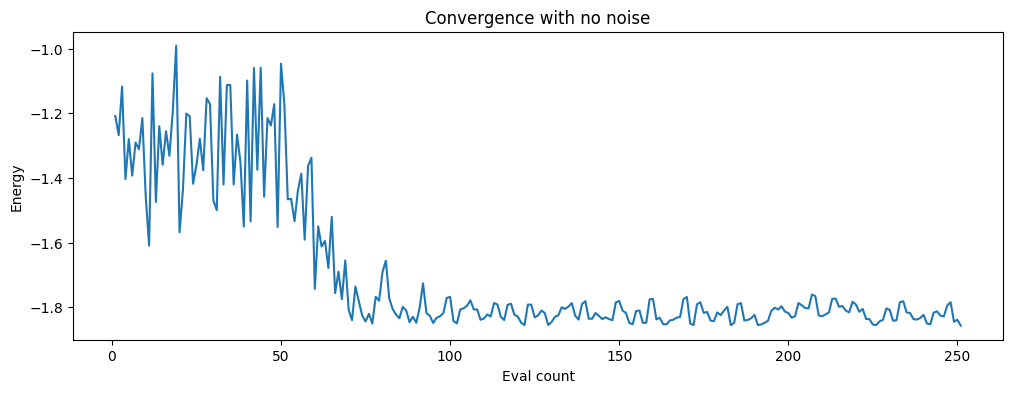

In [850]:

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In [851]:
from qiskit_aer.primitives import Estimator 
counts = []
values = []

In [852]:
p_error = 0.5
bit_flip = pauli_error([("XI", p_error/2), ("IX", p_error/2),("II", 1 - p_error)])

In [853]:
noise_model = NoiseModel()
error_ops = [
    ('II', (1 - p_error) * (1 - p_error)),  
    ('IX', (1 - p_error) * p_error),        
    ('XI', p_error * (1 - p_error)),        
    ('XX', p_error * p_error)               
]

two_qubit_bit_flip = pauli_error(error_ops)
noise_model.add_all_qubit_quantum_error(two_qubit_bit_flip, ['cx'])

In [854]:

estimator = Estimator(
    backend_options={     # or 'density_matrix' for noise
        "noise_model": noise_model,
        # optionally: "coupling_map", "basis_gates", "device", etc.
    },
    transpile_options={
        "seed_transpiler": 42
    },
    run_options={
        "shots": 1024,
        "seed": 42
    },
    approximation=False  # or True for exact expectation without sampling noise
)

In [855]:
nvqe = VQE(estimator, ansatz, optimiizer, callback=store_intermediate_result)
result = nvqe.compute_minimum_eigenvalue(hamiltonian)

print(f"VQE on Aer qasm simulator (with noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (with noise): -1.83656
Delta from reference energy value is 0.02076


Text(0.5, 1.0, 'Convergence with noise')

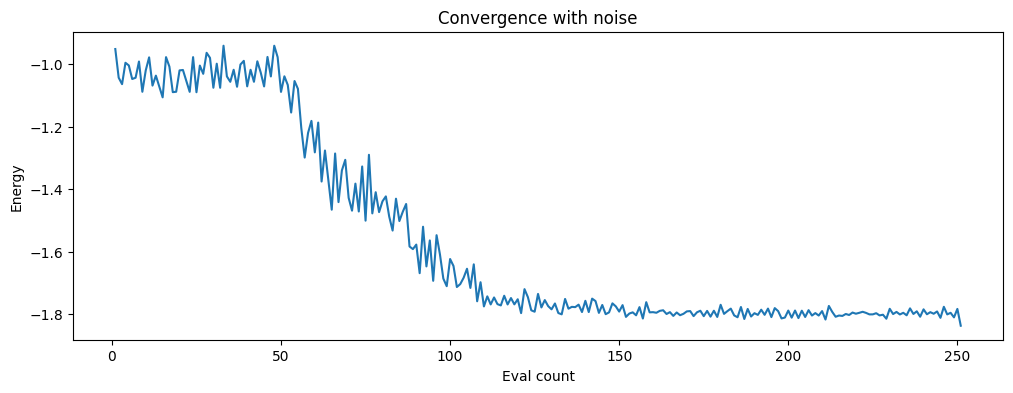

In [856]:

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with noise")

In [857]:
def encoder(circ, reg):
    circ.cx(reg[0], reg[2])

def syndrome(circ, reg, ancilla, reg1):
    circ.cx(reg[0], ancilla[0])
    circ.cx(reg[1], ancilla[0])
    
    circ.cx(reg[1], ancilla[1])
    circ.cx(reg[2], ancilla[1])
    circ.measure(ancilla[0], reg1[0])
    circ.measure(ancilla[1], reg1[1])

def correction(circuit, qreg, creg):
    circuit.x(qreg[0]).c_if(creg, 0b10)
    circuit.x(qreg[1]).c_if(creg, 0b11)
    circuit.x(qreg[2]).c_if(creg, 0b01)
